In [129]:
from tabpfn_client import init, TabPFNClassifier, TabPFNRegressor
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split,StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from scipy.stats import linregress

from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor,XGBClassifier
import warnings
warnings.filterwarnings("ignore")


# Test on Tab

## Data process

In [130]:
metab_df=pd.read_csv('../../../Subtype/data/Using/metab.csv',index_col=0)
sample_df=pd.read_csv('../../../Subtype/data/Using/whole_sample_info.csv',index_col=0)
lipid_df=pd.read_csv('./chemical_sample.csv',index_col=0)

sample_df.index = sample_df['Sample Name']
sample_df.loc[:,['os']]
metab_num=metab_df.shape[1]
lipid_num=lipid_df.shape[1]

survival_df = pd.merge(metab_df, sample_df.loc[:,['os']],left_index=True,right_index=True)

In [131]:
survival_df.columns = survival_df.columns.str.replace(',', '_')


## Features

In [152]:

with open('/home/suh/workstation/MetabSubtype/tasks/MultiOmics/notebooks/survival/metab_shap_sig_features.txt', 'r') as file:
    shap_features = [line.strip() for line in file]

with open('/home/suh/workstation/MetabSubtype/tasks/MultiOmics/notebooks/survival/metab_stat_sig_features.txt', 'r') as file:
    stat_features = [line.strip() for line in file]

with open('/home/suh/workstation/MetabSubtype/tasks/MultiOmics/notebooks/survival/metab_shared_sig_features.txt', 'r') as file:
    shared_features = [line.strip() for line in file]

In [153]:
shap_features = [feature.replace(',','_') for feature in shap_features]
stat_features = [feature.replace(',','_') for feature in stat_features]
shared_features = [feature.replace(',','_') for feature in shared_features]


In [134]:
X = survival_df.iloc[:,:-1]
y = survival_df.iloc[:,[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_selected = survival_df.loc[:,metabolite_features]

In [135]:
model = TabPFNRegressor()
model.fit(X_train, y_train)
# Get predictions
predictions = model.predict(X_test)
# Get probability estimates


Processing: 100%|██████████| [00:02<00:00]


In [136]:
print(y_test)
print(predictions)

                 os
Sample Name        
180224-T      51.00
180041-T      20.33
130222-T      36.13
140263-T      52.57
2706           9.30
2257         125.63
2026          46.07
5058          32.80
7970          39.67
1452          33.13
6927          56.97
2669          18.30
190040-T      21.07
1272          10.87
170046-T      13.20
8775          27.73
354228-T       4.43
170116-T      41.27
2423          90.33
1870          35.17
160229-T      21.47
200095-T      10.30
8575          32.37
4254         104.53
150230-T       7.63
1520         140.67
2139          36.40
150342-T      86.03
4202         102.87
140143-T      30.93
8816          17.17
[34.82122421 36.05291367 52.74786758 40.34541702 41.17963028 47.55577469
 34.81004333 47.13442993 34.7560997  36.74581909 35.70908356 37.34132767
 34.29194641 46.04299164 35.85074615 49.91854477 37.71308899 47.67596817
 42.47262955 34.7565155  39.4769783  35.17043304 43.70465469 46.69427109
 42.82209015 47.46037292 39.81551361 34.89966583

# Compare Regression

In [137]:

# Initialize models
tab_model = TabPFNRegressor()
xgb_model = XGBRegressor()
lasso_model = Lasso()

# Set up KFold cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Store results
tab_preds = []
xgb_preds = []
lasso_preds = []
y_true = []

using_X = X_selected
# 4-Fold cross-validation loop
for train_index, test_index in kf.split(using_X):
    X_train_fold, X_test_fold = using_X.iloc[train_index], using_X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Train TabPFNRegressor
    tab_model.fit(X_train_fold, y_train_fold)
    tab_preds_fold = tab_model.predict(X_test_fold)
    tab_preds.append(tab_preds_fold)
    
    # Train XGBRegressor
    xgb_model.fit(X_train_fold, y_train_fold)
    xgb_preds_fold = xgb_model.predict(X_test_fold)
    xgb_preds.append(xgb_preds_fold)
    
    # Train Lasso
    lasso_model.fit(X_train_fold, y_train_fold)
    lasso_preds_fold = lasso_model.predict(X_test_fold)
    lasso_preds.append(lasso_preds_fold)
    
    # Store true values for plotting
    y_true.append(y_test_fold)

# Flatten the lists of predictions and true values
tab_preds = np.concatenate(tab_preds)
xgb_preds = np.concatenate(xgb_preds)
lasso_preds = np.concatenate(lasso_preds)
y_true = np.concatenate(y_true)


Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]


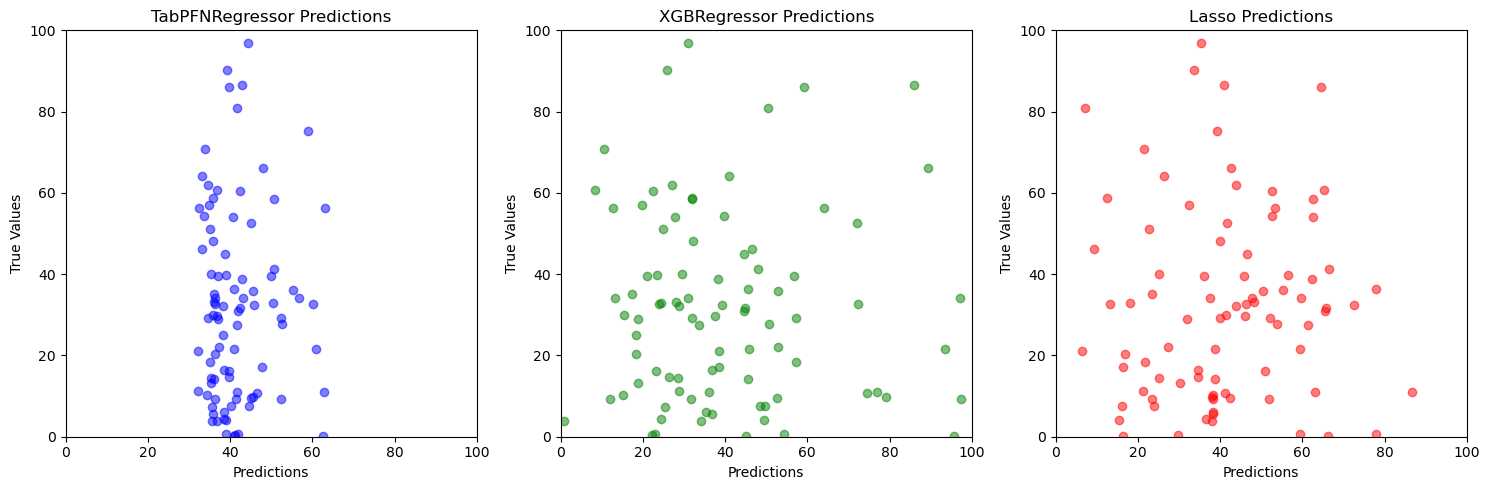

In [138]:

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# TabPFNRegressor plot
axes[0].scatter(tab_preds, y_true, color='blue', alpha=0.5)
axes[0].set_title('TabPFNRegressor Predictions')
axes[0].set_xlabel('Predictions')
axes[0].set_ylabel('True Values')

# XGBRegressor plot
axes[1].scatter(xgb_preds, y_true, color='green', alpha=0.5)
axes[1].set_title('XGBRegressor Predictions')
axes[1].set_xlabel('Predictions')
axes[1].set_ylabel('True Values')

# Lasso plot
axes[2].scatter(lasso_preds, y_true, color='red', alpha=0.5)
axes[2].set_title('Lasso Predictions')
axes[2].set_xlabel('Predictions')
axes[2].set_ylabel('True Values')

for ax in axes:
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])
# Display the plots
plt.tight_layout()
plt.show()

In [139]:
def plot_with_r2(predictions, y_true, ax, model_name):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(predictions, y_true)
    # Calculate R2 score
    r2_score = r_value**2
    print(r_value)

    # Plot scatter plot
    ax.scatter(predictions, y_true, alpha=0.5)

    # Plot the fit line
    # ax.plot(predictions, slope * predictions + intercept, color='red', label=f'Fit Line (R² = {r2_score:.4f})')

    # Annotate the R² score
    # ax.text(min(predictions), max(y_true), f'R² = {r2_score:.4f}', fontsize=12, color='red', ha='left')

    # Set labels and title
    ax.set_xlabel('Predictions')
    ax.set_ylabel('True Values')
    ax.set_title(f'{model_name} Predictions')
    ax.legend()

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 101 and the array at index 1 has size 1

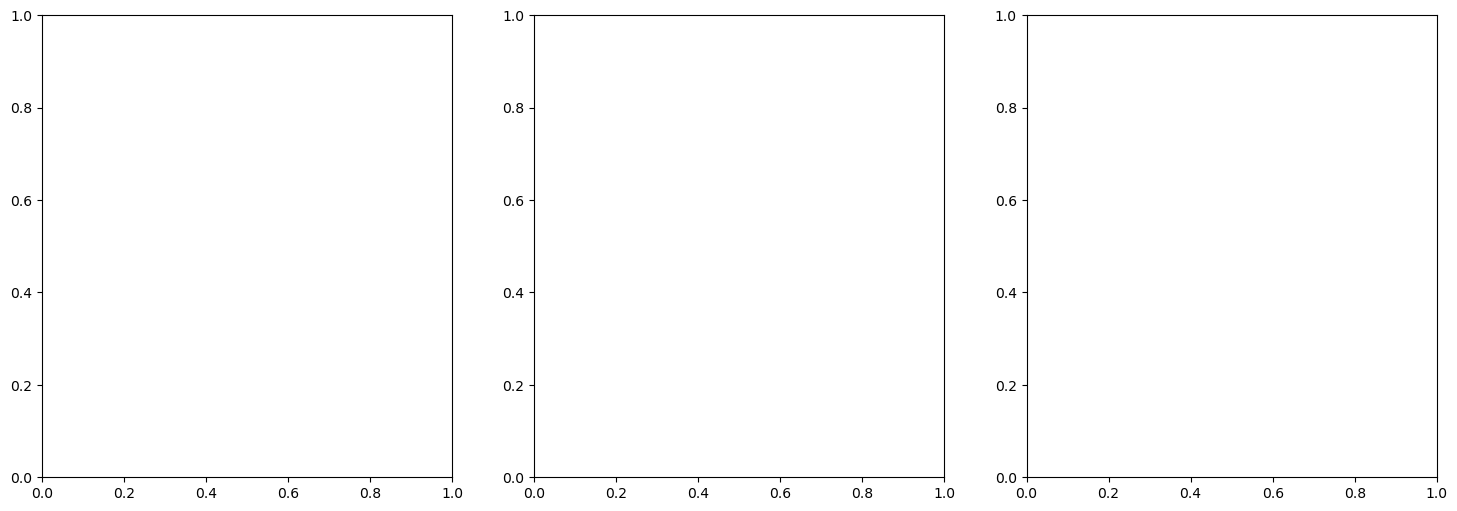

In [140]:
# Plotting the results for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# TabPFNRegressor plot
plot_with_r2(tab_preds, y_true, axes[0], 'TabPFNRegressor')

# XGBRegressor plot
plot_with_r2(xgb_preds, y_true, axes[1], 'XGBRegressor')

# Lasso plot
plot_with_r2(lasso_preds, y_true, axes[2], 'Lasso')

# Display the plots
plt.tight_layout()
plt.show()

# Compare Classification

In [141]:
os_threshold = 24

# Assuming y_train contains the labels for classification and X_train the features
# Split the data into low and high groups based on the threshold
y_train_binary = (y_train > os_threshold).astype(int)  # 1 for high group, 0 for low group
y_binary = (y > os_threshold).astype(int)  # 1 for high group, 0 for low group


In [149]:

# Initialize the models
tab_model = TabPFNClassifier()
xgb_model = XGBClassifier(
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=6,
        eval_metric='logloss'
    )
logreg_model = LogisticRegression()

# Set up Stratified KFold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results for AUC calculation
tab_fpr, tab_tpr, tab_auc = [], [], []
xgb_fpr, xgb_tpr, xgb_auc = [], [], []
logreg_fpr, logreg_tpr, logreg_auc = [], [], []

using_X = X_selected
# 5-Fold cross-validation loop
for train_index, test_index in kf.split(using_X, y_binary):
    X_train_fold, X_test_fold = using_X.iloc[train_index,], using_X.iloc[test_index]
    y_train_fold, y_test_fold = y_binary.iloc[train_index,], y_binary.iloc[test_index]
    
    # Train TabPFNClassifier
    tab_model.fit(X_train_fold, y_train_fold)
    tab_probs = tab_model.predict_proba(X_test_fold)[:, 1]  # Probability of the positive class
    fpr, tpr, _ = roc_curve(y_test_fold, tab_probs)
    tab_fpr.append(fpr)
    tab_tpr.append(tpr)
    tab_auc.append(auc(fpr, tpr))
    
    # Train XGBClassifier
    xgb_model.fit(X_train_fold, y_train_fold)
    xgb_probs = xgb_model.predict_proba(X_test_fold)[:, 1]  # Probability of the positive class
    fpr, tpr, _ = roc_curve(y_test_fold, xgb_probs)
    xgb_fpr.append(fpr)
    xgb_tpr.append(tpr)
    xgb_auc.append(auc(fpr, tpr))
    
    # Train LogisticRegression
    logreg_model.fit(X_train_fold, y_train_fold)
    logreg_probs = logreg_model.predict_proba(X_test_fold)[:, 1]  # Probability of the positive class
    fpr, tpr, _ = roc_curve(y_test_fold, logreg_probs)
    logreg_fpr.append(fpr)
    logreg_tpr.append(tpr)
    logreg_auc.append(auc(fpr, tpr))


Processing: 100%|██████████| [00:00<00:00]
Processing: 100%|██████████| [00:00<00:00]
Processing: 100%|██████████| [00:00<00:00]


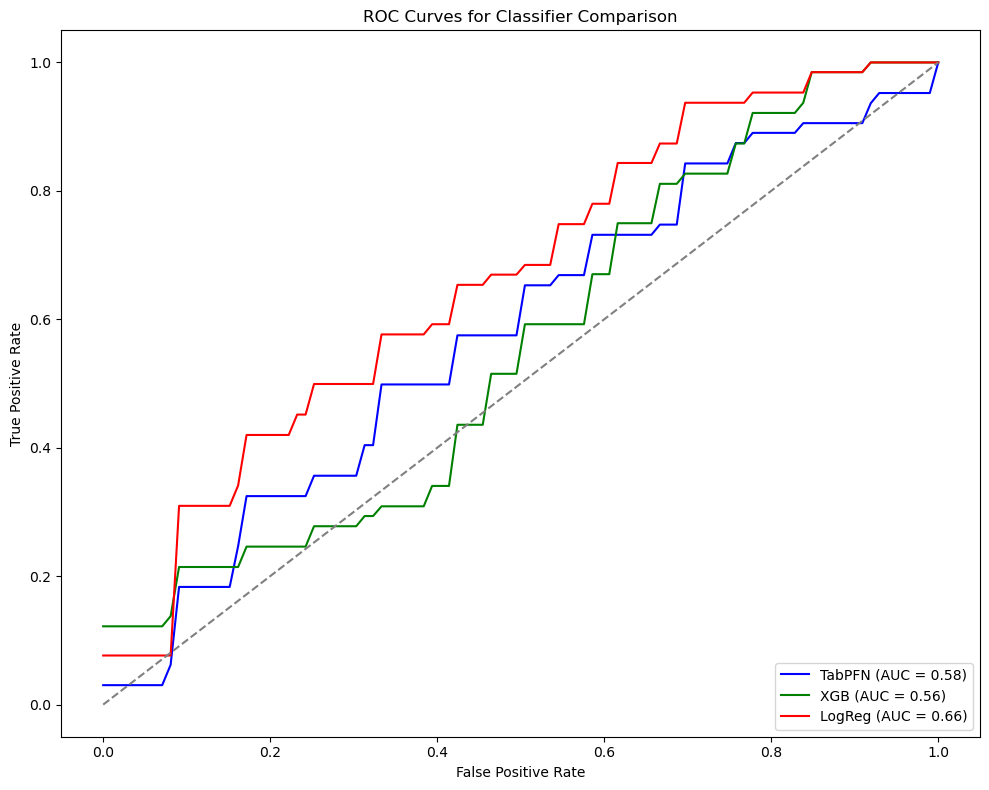

In [150]:

# Average AUC for each model
tab_avg_auc = np.mean(tab_auc)
xgb_avg_auc = np.mean(xgb_auc)
logreg_avg_auc = np.mean(logreg_auc)

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot TabPFNClassifier ROC curve
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(tab_fpr, tab_tpr)], axis=0)
plt.plot(mean_fpr, mean_tpr, color='blue', label=f'TabPFN (AUC = {tab_avg_auc:.2f})')

# Plot XGBClassifier ROC curve
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(xgb_fpr, xgb_tpr)], axis=0)
plt.plot(mean_fpr, mean_tpr, color='green', label=f'XGB (AUC = {xgb_avg_auc:.2f})')

# Plot LogisticRegression ROC curve
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(logreg_fpr, logreg_tpr)], axis=0)
plt.plot(mean_fpr, mean_tpr, color='red', label=f'LogReg (AUC = {logreg_avg_auc:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classifier Comparison')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## 95%CI

In [164]:

from sklearn.utils import resample

def calculate_ci_auc(classifier, X, y, sig_features, n_bootstraps=10000):
    """
    Calculates the 95% confidence interval for the AUC of a classification model
    using bootstrapping.

    Args:
        classifier: Trained classification model class (e.g., XGBClassifier, Lasso, TabPFNClassifier).
        X: Features data.
        y: Target labels.
        sig_features: Significant features to use for training the model.
        n_bootstraps: Number of bootstrap replicates (default: 10000).

    Returns:
        A tuple containing the mean AUC and the 95% confidence interval (lower, upper).
    """
    aucs = []
    fprs = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    for _ in range(n_bootstraps):
        # Create bootstrapped samples for both classes
        X_boot_0, y_boot_0 = resample(X[y.iloc[:,0] == 0], y[y.iloc[:,0] == 0], replace=True)
        X_boot_1, y_boot_1 = resample(X[y.iloc[:,0] == 1], y[y.iloc[:,0] == 1], replace=True)
        X_boot = pd.concat([X_boot_0, X_boot_1])
        y_boot = pd.concat([y_boot_0, y_boot_1])
        X_boot = X_boot.loc[:, sig_features]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X_boot, y_boot, test_size=0.3, stratify=y_boot)

        # Instantiate and fit the model
        if classifier == "tab":
            model = TabPFNClassifier()
        elif classifier == "xgb":
            model = XGBClassifier(use_label_encoder=False, learning_rate=0.1, n_estimators=1000, max_depth=6, eval_metric='logloss')
        elif classifier == "lasso":
            model = Lasso(alpha = 0.1)  # Adjust alpha based on model tuning
        else:
            raise ValueError(f"Unsupported classifier: {classifier}")

        # Fit model and predict probabilities
        model.fit(X_train, y_train.iloc[:,0].values)
        
        if classifier == "lasso":
            probas_ = model.predict(X_test)  # For Lasso, we need to ensure it's a classifier
        else:
            probas_ = model.predict_proba(X_test)[:, 1]  # Get probabilities for positive class

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test.iloc[:,0].values, probas_)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

    # Calculate confidence interval (assuming normal distribution)
    confidence_level = 0.95
    alpha = 1 - confidence_level
    percentiles = [100 * alpha / 2, 100 * (1-alpha/2)]
    ci = np.percentile(aucs, percentiles)
    
    mean_tpr = np.mean(tprs,axis=0)
    mean_tpr[-1] = 1.0
    mean_tpr[0] = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    mean_auc=np.mean(aucs)
    std_auc=np.std(aucs)
    print(f"AUCs: {aucs}")
    print(f"95% CI: {ci}")

    return mean_fpr, mean_tpr, aucs, ci


In [ ]:

# Example of usage:
# Assuming `X`, `y`, and `sig_features` are defined (e.g., from your dataset)
# Calculate AUC and CI for XGB
mean_fpr_xgb, mean_tpr_xgb, aucs, ci_auc_xgb = calculate_ci_auc("xgb", X, y_binary, shared_features)

# Calculate AUC and CI for TabPFN
mean_fpr_tab, mean_tpr_tab, aucs, ci_auc_tab = calculate_ci_auc("tab", X, y_binary, shared_features)

# Calculate AUC and CI for Lasso
mean_fpr_lasso, mean_tpr_lasso, aucs, ci_auc_lasso = calculate_ci_auc("lasso", X, y_binary, shared_features)

In [ ]:

# Example of usage:
# Assuming `X`, `y`, and `sig_features` are defined (e.g., from your dataset)
# Calculate AUC and CI for XGB
mean_fpr_xgb, mean_tpr_xgb, aucs, ci_auc_xgb = calculate_ci_auc("xgb", X, y_binary, shared_features)

# Calculate AUC and CI for TabPFN
mean_fpr_tab, mean_tpr_tab, aucs, ci_auc_tab = calculate_ci_auc("tab", X, y_binary, shared_features)

# Calculate AUC and CI for Lasso
mean_fpr_lasso, mean_tpr_lasso, aucs, ci_auc_lasso = calculate_ci_auc("lasso", X, y_binary, shared_features)

In [165]:
mean_fpr_lasso, mean_tpr_lasso, aucs_lasso, ci_auc_lasso = calculate_ci_auc("lasso", X, y_binary, shared_features)

ValueError: y should be a 1d array, got an array of shape (31, 2) instead.

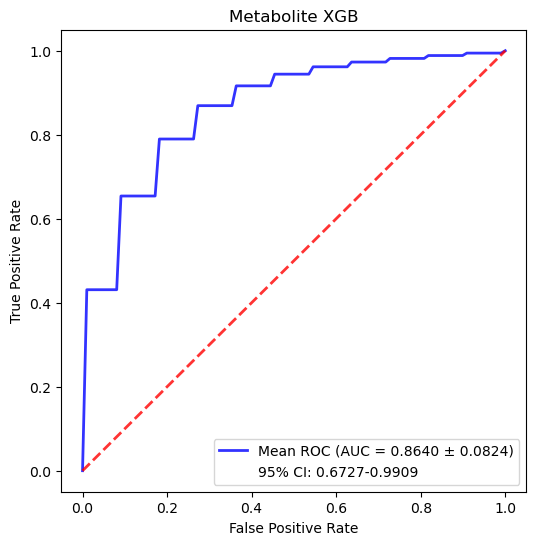

In [158]:
mean_auc_xgb = np.mean(aucs)
std_auc_xgb = np.std(aucs)
fig,ax=plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)
ax.plot(mean_fpr_xgb, mean_tpr_xgb, color='b',
        label=f'Mean ROC (AUC = {mean_auc_xgb:.4f} ± {std_auc_xgb:.4f})',
        lw=2, alpha=.8)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot([],[],' ',label=f'95% CI: {ci_auc_xgb[0]:.4f}-{ci_auc_xgb[1]:.4f}')
ax.set_title(f'Metabolite XGB')
ax.legend(loc='lower right')

# plt.savefig("../../results/20240822_survival/chemotherapy/metab_mean_auc.pdf")